In [1]:
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch import optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Fix random seeds for reproducibility
import numpy as np
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.use_deterministic_algorithms(True)

In [113]:
class OscillatoryGridCell1D(nn.Module):
    def __init__(self, *args, randomize=True, dtype=torch.float32, device="cpu", **kwargs):
        super().__init__(*args, **kwargs)

        self.device = device
        self.dtype = dtype

        self.shift = self._init_param(0, lambda x: nn.init.uniform_(x, 0, 1) if randomize else x, requires_grad=False)
        self.scaling = self._init_param(1, lambda x: nn.init.uniform_(x, 0.1, 1) if randomize else x)

    def forward(self, position):
        """Encode a point on a cartesian 1D axis to a grid cell activation."""
        # We scale only the coordinates to keep the shift in the [0, 1] range
        position = self.scaling * position - self.shift
        return (torch.cos(2 * torch.pi * position) + 1) / 2

    def _init_param(self, default_value, init_function, requires_grad=True):
        param = torch.tensor(default_value, dtype=self.dtype, device=self.device)
        init_function(param)
        param = nn.Parameter(param, requires_grad=requires_grad)
        return param

In [114]:
class GridCellArray1D(nn.Module):
    def __init__(self, n_neurons, *args, dtype=torch.float32, device="cpu", **kwargs):
        super().__init__(*args, **kwargs)

        self.device = device
        self.dtype = dtype

        assert n_neurons > 0, "Number of neurons must be positive."
        self.neurons = nn.ModuleList([OscillatoryGridCell1D(dtype=dtype, device=device) for _ in range(n_neurons)])

    def forward(self, position):
        """Encode a point on a cartesian 2D plane to a vector of grid cell neuron activations."""
        return torch.stack([cell(position) for cell in self.neurons], dim=-1).squeeze(dim=0)

In [115]:
grid_cell = OscillatoryGridCell1D(randomize=False, dtype=torch.float32, device=device)

In [116]:
grid_cell(0)

tensor(1., grad_fn=<DivBackward0>)

In [117]:
positions = torch.tensor([-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1], dtype=torch.float32, device=device)

grid_cell(positions)

tensor([1.0000, 0.5000, 0.0000, 0.5000, 1.0000, 0.5000, 0.0000, 0.5000, 1.0000],
       grad_fn=<DivBackward0>)

In [118]:
N = 1001
x_min, x_max = -1, 1

positions = torch.linspace(x_min, x_max, N, dtype=torch.float32, device=device)

In [119]:
randomized_grid_cell = OscillatoryGridCell1D(randomize=True, dtype=torch.float32, device=device)

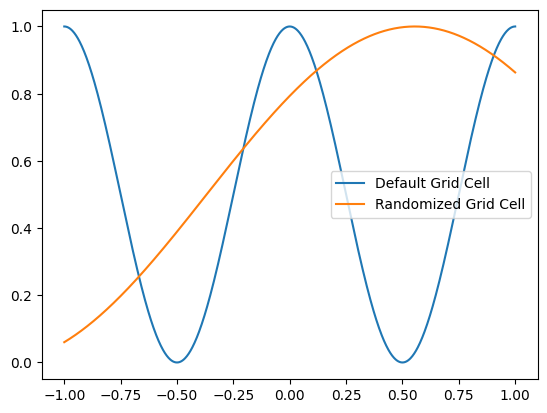

In [120]:
plt.plot(positions, grid_cell(positions).detach().numpy(), label="Default Grid Cell")
plt.plot(positions, randomized_grid_cell(positions).detach().numpy(), label="Randomized Grid Cell")
plt.legend()

In [121]:
randomized_grid_cell.shift, randomized_grid_cell.scaling

(Parameter containing:
 tensor(0.1502),
 Parameter containing:
 tensor(0.2708, requires_grad=True))

In [122]:
grid_cell_array = GridCellArray1D(5, dtype=torch.float32, device=device)

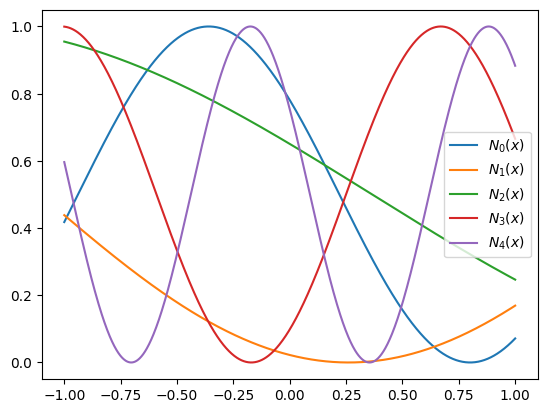

In [123]:
for i, neuron in enumerate(grid_cell_array.neurons):
    plt.plot(positions, neuron(positions).detach().numpy(), label=f"$N_{i}(x)$")

plt.legend()

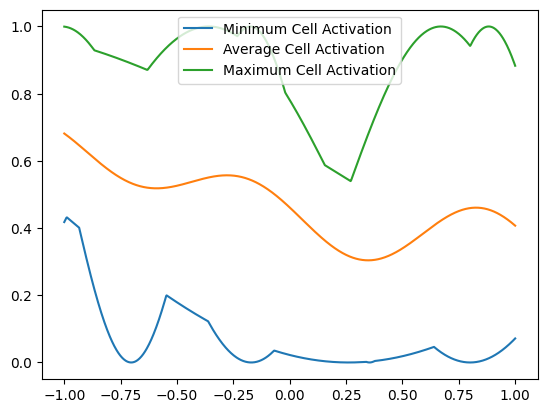

In [124]:
plt.plot(positions, grid_cell_array(positions).min(axis=-1).values.detach().numpy(), label="Minimum Cell Activation")
plt.plot(positions, grid_cell_array(positions).mean(axis=-1).detach().numpy(), label="Average Cell Activation")
plt.plot(positions, grid_cell_array(positions).max(axis=-1).values.detach().numpy(), label="Maximum Cell Activation")

plt.legend()

In [125]:
class LinearDecoder1D(nn.Module):
    def __init__(self, grid_cell_array, *args, weighted=True, weight_normalization=None, probability_normalization=None, dtype=torch.float32, device="cpu", **kwargs):
        super().__init__(*args, **kwargs)

        self.device = device
        self.dtype = dtype

        self.n_neurons = len(grid_cell_array.neurons)

        self.grid_cell_array = grid_cell_array

        # We don't need need bias because we will be inferring the predicted position from the maximum activation value
        weights_ = torch.ones(self.n_neurons, dtype=dtype, device=device)
        if weighted:
            nn.init.normal_(weights_, 0, 1)
        self.weights_ = nn.Parameter(weights_, requires_grad=weighted)
        if weight_normalization is None:
            self.normalize_weights = lambda x: x
        elif weight_normalization == "softmax":
            self.normalize_weights = nn.Softmax(dim=-1)
        elif weight_normalization == "linear":
            self.normalize_weights = lambda x: x / torch.sum(x)
        elif weight_normalization == "squared":
            # The squared normalization is useful to enforce the weights to be positive
            self.normalize_weights = lambda x: x ** 2 / torch.sum(x ** 2)
        else:
            raise ValueError("Invalid weight normalization method.")

        if probability_normalization is None:
            self.normalize_probabilities = lambda x: x
        elif probability_normalization == "softmax":
            self.normalize_probabilities = nn.Softmax(dim=-1)
        elif probability_normalization == "linear":
            self.normalize_probabilities = lambda x: x / torch.sum(x)
        elif probability_normalization == "squared":
            self.normalize_probabilities = lambda x: x ** 2 / torch.sum(x ** 2)
        else:
            raise ValueError("Invalid probability normalization method.")

    def forward(self, true_activations, position_estimates):
        """Decode the neuron representation"""
        assert (true_activations.shape[-1] == self.n_neurons), "The number of neurons in the grid cell array must match the number of neurons used the true activations."
        assert len(true_activations.shape) <= 2, "The true activations must be a tensor of shape (n_true_positions, n_neurons)."
        if len(true_activations.shape) == 1:
            true_activations = true_activations.reshape(1, self.n_neurons)

        # 1. Compute the activation for possible X estimations
        estimated_activations = self.grid_cell_array(position_estimates)

        # 2. Multiply it by the activations for the true positions (it will discriminate against the other positions)
        # TODO: Optimize this step using better vectorization technique
        if len(estimated_activations.shape) == 1:
            estimated_activations = estimated_activations.reshape(1, -1)

        # Target: (nt_1, nt_2, ...), Estimated point: (ne_1, ne_2, ...) -> Disctriminated activations: (nt_1 * ne_1, nt_2 * nt_2, ...)
        discriminated_activations = (estimated_activations.expand(true_activations.shape[0], -1, -1).transpose(0, 1) * true_activations).transpose(0, 1)
        # 3. Compute the weighted sum using the decoder weights (the decoder will consider some neurons more "valuable" than others)
        # Decoded activation value: w1 * nt_1 * ne_1 + w2 * nt_2 * ne_2 + ..
        decoded_activations = discriminated_activations @ self.weights()
        # Apply normalization to get the position probability distribution estimate
        position_probabilities = self.normalize_probabilities(decoded_activations.reshape(true_activations.shape[0], -1))
        # 4. Find the position expectations by computing the weighted sum of the position estimations' probabilities
        # Probabilities: p1, p2, ..., Estimates: xe1, xe2, ..., Expectation: (p1 * xe1 + p2 * xe2 + ...) / (p1 + p2 + ...)
        position_expectations = (position_probabilities @ position_estimates) / position_probabilities.sum(dim=-1)
        # arg_x(max_p((p1, xe1), (p2, xe2), ...))
        most_probable_positions = position_estimates[position_probabilities.argmax(dim=-1)]
        return position_probabilities, position_expectations, most_probable_positions

    def weights(self):
        # Note that we may use the normalization to force the weights to sum up to 1
        return self.normalize_weights(self.weights_)

In [126]:
decoder = LinearDecoder1D(grid_cell_array, dtype=torch.float32, device=device, weighted=False, weight_normalization="softmax", probability_normalization=None)
decoder.weights()

tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000])

In [127]:
true_x = torch.tensor([0.5], dtype=torch.float32, device=device)
true_activations = grid_cell_array(true_x)
true_activations

tensor([0.1564, 0.0186, 0.4437, 0.9024, 0.1767], grad_fn=<SqueezeBackward1>)

In [128]:
positions = torch.tensor([0.5], dtype=torch.float32, device=device)

position_probabilities, position_expectations, most_probable_positions = decoder(true_activations, positions)

print((true_activations.reshape(1, -1) ** 2).mean(dim=-1))

position_probabilities, position_expectations, most_probable_positions

tensor([0.2134], grad_fn=<MeanBackward1>)


(tensor([[0.2134]], grad_fn=<ReshapeAliasBackward0>),
 tensor([0.5000], grad_fn=<DivBackward0>),
 tensor([0.5000]))

In [129]:
decoder = LinearDecoder1D(grid_cell_array, dtype=torch.float32, device=device, weighted=False, weight_normalization=None, probability_normalization="softmax")
decoder.weights()

Parameter containing:
tensor([1., 1., 1., 1., 1.])

In [130]:
positions = torch.tensor([-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1], dtype=torch.float32, device=device)

decoder(true_activations, positions)

(tensor([[0.1804, 0.1370, 0.0967, 0.0785, 0.0754, 0.0877, 0.1165, 0.1312, 0.0966]],
        grad_fn=<SoftmaxBackward0>),
 tensor([-0.0759], grad_fn=<DivBackward0>),
 tensor([-1.]))

In [131]:
true_x = torch.tensor([0, 0.5, 1, 10], dtype=torch.float32, device=device)
true_activations = grid_cell_array(true_x)
true_activations

tensor([[0.7811, 0.0223, 0.6506, 0.0982, 0.7543],
        [0.1564, 0.0186, 0.4437, 0.9024, 0.1767],
        [0.0715, 0.1692, 0.2466, 0.6657, 0.8831],
        [0.0106, 0.4102, 0.0115, 0.0239, 0.1461]], grad_fn=<SqueezeBackward1>)

In [132]:
positions = torch.tensor([-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1], dtype=torch.float32, device=device)

decoder(true_activations, positions)

(tensor([[0.1307, 0.1029, 0.1399, 0.2081, 0.1455, 0.0668, 0.0546, 0.0763, 0.0751],
         [0.1804, 0.1370, 0.0967, 0.0785, 0.0754, 0.0877, 0.1165, 0.1312, 0.0966],
         [0.1692, 0.0867, 0.0823, 0.1124, 0.0947, 0.0655, 0.0883, 0.1642, 0.1366],
         [0.1281, 0.1110, 0.1094, 0.1144, 0.1082, 0.0979, 0.1003, 0.1133, 0.1173]],
        grad_fn=<SoftmaxBackward0>),
 tensor([-0.1536, -0.0759,  0.0168, -0.0178], grad_fn=<DivBackward0>),
 tensor([-0.2500, -1.0000, -1.0000, -1.0000]))

In [133]:
grid_cell_array = GridCellArray1D(5, dtype=torch.float32, device=device)
decoder = LinearDecoder1D(grid_cell_array, dtype=torch.float32, device=device, weighted=True, probability_normalization="softmax")

N = 1001
x_min, x_max = -1, 1

positions = torch.linspace(x_min, x_max, N, dtype=torch.float32, device=device)

true_positions = torch.tensor([0, 0.5, 1, -1, -0.5], dtype=torch.float32, device=device)

true_activations = grid_cell_array(true_positions)
position_probabilities, position_expectations, most_probable_positions = decoder(true_activations, positions)
print(position_probabilities.shape)
print(position_expectations)
print(most_probable_positions)

torch.Size([5, 1001])
tensor([ 0.0126,  0.0241,  0.0464,  0.0237, -0.0023], grad_fn=<DivBackward0>)
tensor([0.1780, 0.0520, 1.0000, 1.0000, 0.0520])


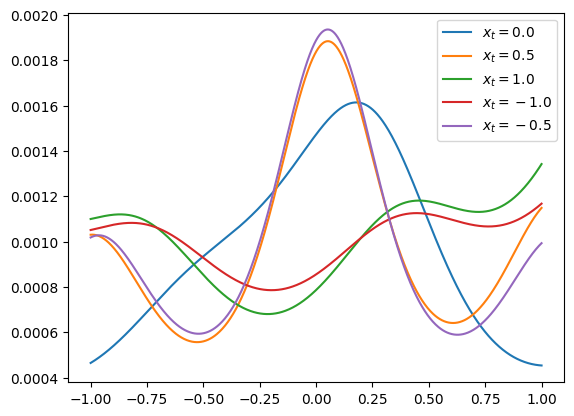

In [134]:
for i, true_position in enumerate(true_positions):
    plt.plot(positions, position_probabilities[i].detach().numpy(), label=f"$x_t={true_position}$")

plt.legend()

In [164]:
from sklearn.model_selection import train_test_split

In [172]:
def train(*,
    n_neurons=5,
    weighted_decoder=True,
    weight_normalization=None,
    probability_normalization="softmax",
    # Training Domain
    x_min=-1,
    x_max=1,
    n_positions=1000,
    # Validation Domain
    val_size=0.2,
    # Training Parameters
    max_epochs=10000,
    target_loss=0.01,
    batch_size=100,
    optimizer="adam",
    learning_rate=0.01,

    random_seed=None,
    verbose=True,
    dtype=torch.float32,
    device="cpu",
):
    if random_seed is not None:
        random.seed(random_seed)
        np.random.seed(random_seed)
        torch.manual_seed(random_seed)
        torch.use_deterministic_algorithms(True)


    # Define the training domain
    positions = torch.empty(n_positions, dtype=dtype, device=device)
    positions = torch.linspace(x_min, x_max, n_positions)
    train_positions, val_positions = train_test_split(positions, test_size=val_size, shuffle=True, random_state=random_seed)
    #torch.nn.init.uniform_(positions, -1, 1)

    # Define the grid cell array and the decoder
    grid_cell_array = GridCellArray1D(n_neurons, dtype=dtype, device=device)
    decoder = LinearDecoder1D(
        grid_cell_array,
        weighted=weighted_decoder,
        weight_normalization=weight_normalization,
        probability_normalization=probability_normalization,
        dtype=dtype,
        device=device,
    )

    # Define the optimizer
    if optimizer == "adam":
        optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    elif optimizer == "sgd":
        optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    else:
        raise ValueError("Invalid optimizer.")

    model_converged = False

    for epoch in range(max_epochs):
        # Generate random positions for the epoch
        # TODO: Use DataSet and DataLoader
        positions = positions[torch.randperm(n_positions, device=device)]
        for i in range(0, n_positions, batch_size):
            optimizer.zero_grad()

            batch_positions = positions[i:i + batch_size]
            true_activations = grid_cell_array(batch_positions)
            position_probabilities, position_expectations, _ = decoder(true_activations, batch_positions)

            loss = 0

            ## Distance to the expected value (seems to be the worst)
            ## TODO: Use MSE loss from torch.nn
            #loss += ((position_expectations - batch_positions) ** 2).mean()

            # Variance (not the best but adds stability)
            loss += (((batch_positions.expand(batch_size, -1).T - batch_positions) ** 2).sum(dim=-1) * position_probabilities).mean()

            # Negative log probability for true positions:
            loss -= torch.log(position_probabilities.diagonal()).sum()

            # Regularize agaist decoder weight difference:
            loss += (decoder.weights() ** 2).mean()

            loss.backward()
            optimizer.step()

        val_true_activations = grid_cell_array(val_positions)
        _, _, val_most_probable_positions = decoder(val_true_activations, val_positions)
        val_loss = ((val_most_probable_positions - val_positions) ** 2).mean()
        if val_loss < target_loss:
            model_converged = True
            break
        if verbose:
            print(f"Epoch {epoch + 1}: Validation Loss: {val_loss.item()}")


    return grid_cell_array, decoder, model_converged

In [179]:
grid_cell_array, decoder, model_converged = train(
    n_neurons=10,
    weighted_decoder=True,
    weight_normalization=None,
    probability_normalization="softmax",
    x_min=-1,
    x_max=1,
    n_positions=1000,
    val_size=0.2,
    # Training Parameters
    max_epochs=10000,
    target_loss=0.001,
    batch_size=100,
    optimizer="adam",
    learning_rate=0.01,
    random_seed=42,
    verbose=True,
    dtype=torch.float32,
    device=device,
)

print(model_converged)

Epoch 1: Validation Loss: 0.27760714292526245
Epoch 2: Validation Loss: 0.2145313024520874
Epoch 3: Validation Loss: 0.18994781374931335
Epoch 4: Validation Loss: 0.1928345263004303
Epoch 5: Validation Loss: 0.20469725131988525
Epoch 6: Validation Loss: 0.1940573900938034
Epoch 7: Validation Loss: 0.18719562888145447
Epoch 8: Validation Loss: 0.1832575649023056
Epoch 9: Validation Loss: 0.15600468218326569
Epoch 10: Validation Loss: 0.12814529240131378
Epoch 11: Validation Loss: 0.19332696497440338
Epoch 12: Validation Loss: 0.322742223739624
Epoch 13: Validation Loss: 0.31234121322631836
Epoch 14: Validation Loss: 0.28811442852020264
Epoch 15: Validation Loss: 0.07029952853918076
Epoch 16: Validation Loss: 0.02213493175804615
Epoch 17: Validation Loss: 0.017586275935173035
Epoch 18: Validation Loss: 0.0122534753754735
Epoch 19: Validation Loss: 0.00936526246368885
Epoch 20: Validation Loss: 0.00682614604011178
Epoch 21: Validation Loss: 0.0055518983863294125
Epoch 22: Validation Loss:

In [180]:
decoder.weights()

Parameter containing:
tensor([ 3.6527,  4.4599,  4.3700,  2.1019, -2.3006,  3.4938,  5.0188,  4.1837,
         3.3834,  2.8359], requires_grad=True)

torch.Size([5, 1001])
tensor([1.0000, 1.5000, 2.0000, 2.5000, 3.0000])
tensor([1.6692, 1.4526, 1.5165, 1.6387, 1.4211], grad_fn=<DivBackward0>)
tensor([1.2560, 1.2540, 1.6140, 1.2260, 1.2340])


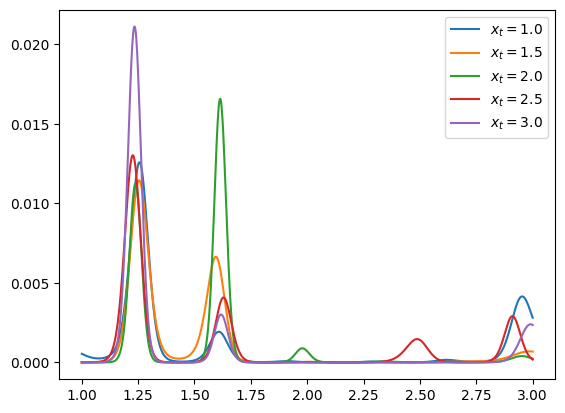

In [181]:
N = 1001
x_min, x_max = 1, 3

positions = torch.linspace(x_min, x_max, N, dtype=torch.float32, device=device)

true_positions = torch.tensor([1, 1.5, 2, 2.5, 3], dtype=torch.float32, device=device)

true_activations = grid_cell_array(true_positions)
position_probabilities, position_expectations, most_probable_positions = decoder(true_activations, positions)
print(position_probabilities.shape)
print(true_positions)
print(position_expectations)
print(most_probable_positions)

for i, true_position in enumerate(true_positions):
    plt.plot(positions, position_probabilities[i].detach().numpy(), label=f"$x_t={true_position}$")

plt.legend()

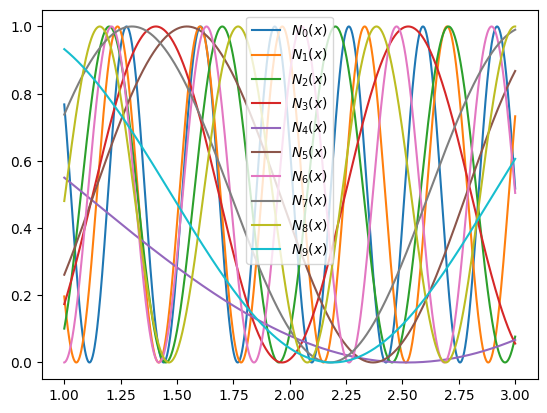

In [182]:
for i, neuron in enumerate(grid_cell_array.neurons):
    plt.plot(positions, neuron(positions).detach().numpy(), label=f"$N_{i}(x)$")

plt.legend()

In [183]:
scalings = [neuron.scaling.item() for neuron in grid_cell_array.neurons]


(array([2., 2., 1., 0., 0., 1., 1., 1., 1., 1.]),
 array([0.17481062, 0.46155116, 0.74829171, 1.03503225, 1.3217728 ,
        1.60851334, 1.89525388, 2.18199443, 2.46873497, 2.75547552,
        3.04221606]),
 <BarContainer object of 10 artists>)

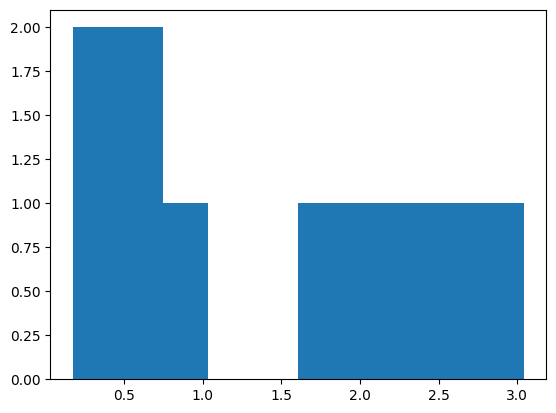

In [184]:
plt.hist(sorted(scalings))

In [185]:
sorted(scalings)

[0.17481061816215515,
 0.3501987159252167,
 0.5699498653411865,
 0.6053382158279419,
 0.8934307098388672,
 1.6292344331741333,
 1.9933099746704102,
 2.3726491928100586,
 2.7366385459899902,
 3.0422160625457764]

In [188]:
from tqdm.notebook import trange

frequency_distributions = []
for _ in trange(100):
    model_converged = False
    grid_cell_array = None
    while not model_converged:
        grid_cell_array, _, model_converged = train(
            n_neurons=10,
            weighted_decoder=True,
            weight_normalization=None,
            probability_normalization="softmax",
            x_min=-1,
            x_max=1,
            n_positions=1000,
            val_size=0.2,
            max_epochs=100,
            target_loss=0.001,
            batch_size=100,
            optimizer="adam",
            learning_rate=0.01,
            random_seed=None,
            verbose=False,
            dtype=torch.float32,
            device=device,
        )
        if not model_converged:
            print("Model didn't converge, retrying")
    frequency_distributions += [neuron.scaling.item() for neuron in grid_cell_array.neurons]


  0%|          | 0/100 [00:00<?, ?it/s]

Model didn't converge, retrying
Model didn't converge, retrying
Model didn't converge, retrying
Model didn't converge, retrying
Model didn't converge, retrying
Model didn't converge, retrying
Model didn't converge, retrying
Model didn't converge, retrying
Model didn't converge, retrying
Model didn't converge, retrying
Model didn't converge, retrying
Model didn't converge, retrying
Model didn't converge, retrying
Model didn't converge, retrying
Model didn't converge, retrying
Model didn't converge, retrying
Model didn't converge, retrying
Model didn't converge, retrying
Model didn't converge, retrying
Model didn't converge, retrying
Model didn't converge, retrying
Model didn't converge, retrying
Model didn't converge, retrying
Model didn't converge, retrying
Model didn't converge, retrying
Model didn't converge, retrying
Model didn't converge, retrying
Model didn't converge, retrying
Model didn't converge, retrying
Model didn't converge, retrying
Model didn't converge, retrying
Model di

(array([  1.,   0.,   3., 131., 298., 300., 202.,  53.,   9.,   3.]),
 array([-2.03133535, -1.45824311, -0.88515086, -0.31205862,  0.26103363,
         0.83412588,  1.40721812,  1.98031037,  2.55340261,  3.12649486,
         3.69958711]),
 <BarContainer object of 10 artists>)

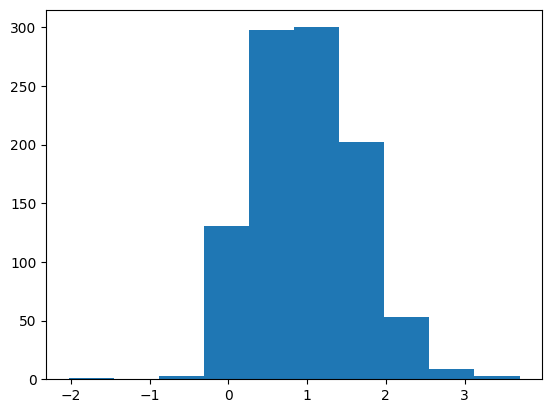

In [189]:
plt.hist(frequency_distributions)